In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import helpers as help
import implementations as imp
import data_helpers as dhelp
from collections import Counter

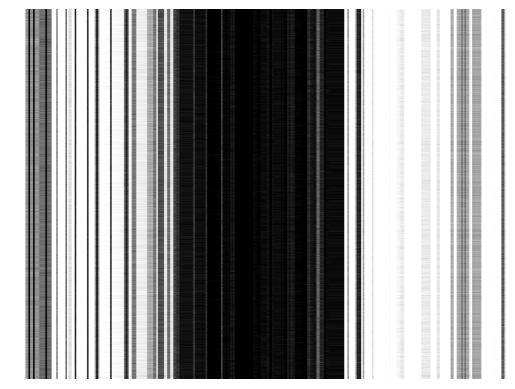

In [2]:
####### Plots a visualization of existing values (black) and NaN values (white) in the training dataset cells.
# Input data formatting
cd = os.getcwd()
path_Xtest = os.path.join(cd, "datasets", "x_train.csv")

# Read the CSV file using NumPy
data = np.genfromtxt(path_Xtest, delimiter=',', skip_header=1)

# Create a mask for NaN values
mask = np.isnan(data)

# Create a figure and axis
fig, ax = plt.subplots()

# Display the grid with NaN values in white and other values in black
ax.imshow(mask, cmap='gray_r', aspect='auto')



# Hide the axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Show the plot
plt.show()

In [3]:
cd = os.getcwd()
path = os.path.join(cd, "datasets")

# Removing columns with many NaNs (0 means no NaNs at all)
[x_data, x_validation, y_data, data_ids, validation_ids] = help.load_csv_data(path)

x_data_safe = x_data
x_validation_safe = x_validation
y_data_safe = y_data

In [4]:
# to ignore
x_data = x_data_safe
x_validation = x_validation_safe

## IMPROVABLE
# Exception values, to know which exception value index to use, compute average of columns, if average between 0 and 9 use index 0, etc
#badCodes = [900,7777,98,99999,99900]
badCodes = [88,888,77,99900,99999,7777]

# # numdays_healthy
x_data[x_data[:, 28] == 88, 28] = 0
x_validation[x_validation[:, 28] == 88, 28] = 0
x_data[x_data[:, 29] == 88, 29] = 0
x_validation[x_validation[:, 29] == 88, 29] = 0
x_data[x_data[:, 30] == 88, 30] = 0
# alcohol
x_validation[x_validation[:, 30] == 88, 30] = 0
x_data[x_data[:, 78] == 888, 78] = 0
x_validation[x_validation[:, 78] == 888, 78] = 0
x_data[x_data[:, 80] == 88, 80] = 0
x_validation[x_validation[:, 80] == 88, 80] = 0
# fruitjuice
x_data[x_data[:, 82] == 555, 82] = 0
x_validation[x_validation[:, 80] == 555, 80] = 0
#strength
x_data[x_data[:, 95] == 888, 95] = 0
x_validation[x_validation[:, 95] == 888, 95] = 0
# CHILDREN
x_data[x_data[:, 60] == 88, 60] = 0
x_validation[x_validation[:, 60] == 88, 60] = 0

# Replace values equal to 88 with the column mean
for code in badCodes:
    if code == 888 or code == 88:
        x_data = np.where(x_data == code, 0, x_data)
        x_validation = np.where(x_validation == code, 0, x_validation)
    else:
        temp_data = np.where(x_data == code, np.nan, x_data)
        col_means = np.nanmean(temp_data, axis=0)
        x_data = np.where(x_data == code, col_means, x_data)
        x_validation = np.where(x_validation == code, col_means, x_validation)

# Remove useless columns
x_data = np.delete(x_data, [2,3,4,5,7,8,9,14,18,53,54], 1)
x_validation = np.delete(x_validation, [2,3,4,5,7,8,9,14,18,53,54], 1)


In [54]:
# Parameters to adjust
nans_threshold = 0.9
decay_rate = 0.001
degree_vector = [2]
max_iters = 500
gamma_values = [ 0.38285714285714284]
#gamma_values = np.linspace(0.36,0.44,15)
lambda_values = [0, 0.01, 0.00001] # also possible to use 0
batch_size = 10000

In [6]:
N = x_data.shape[0]
M = x_data.shape[1]
x_validation = x_validation[:, (np.count_nonzero(np.isnan(x_data), axis = 0) <= nans_threshold * N) ]
x_data = x_data[:, (np.count_nonzero(np.isnan(x_data), axis = 0) <= nans_threshold * N) ]

#Processing remaining NaNs
x_data = np.where(np.isnan(x_data), np.ma.array(x_data, 
            mask = np.isnan(x_data)).mean(axis = 0), x_data)    
x_validation= np.where(np.isnan(x_validation), np.ma.array(x_validation, 
            mask = np.isnan(x_validation)).mean(axis = 0), x_validation) 

# x_data = np.where(np.isnan(x_data), np.nanmedian(x_data, axis=0), x_data)
# x_validation = np.where(np.isnan(x_validation), np.nanmedian(x_validation, axis=0), x_validation)

# Removing columns with 0 variance
x_validation = x_validation[:, np.std(x_data, axis = 0) != 0 ]
x_data = x_data[:, np.std(x_data, axis = 0) != 0 ]

std_dev = np.std(x_data, axis=0)
mean = np.mean(x_data, axis=0)

x_data = dhelp.standardize(x_data)
x_validation = dhelp.standardize(x_validation)

print(x_data.shape[1])

210


In [7]:
correlation_matrix = np.corrcoef(x_data, rowvar=False)
upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1)

to_drop = set()
correlation_threshold = 0.9
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix[i, j]) > correlation_threshold:
            to_drop.add(j)

x_data = np.delete(x_data, list(to_drop), axis=1)
x_validation = np.delete(x_validation, list(to_drop), axis=1)
M_cleaned = x_data.shape[1]

print("after selection: ")
print(x_data.shape[1])

[x_train, x_test, y_train, y_test] = dhelp.split_data(x_data, y_data, ratio=0.85, seed=1)

after selection: 
177


In [45]:
# Functions

# Compute sigma(t)
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

# Computes the gradient for regularized logistic regression 
def compute_gradient(y, tx, w, class_weight, lambda_):
    N = y.shape[0]

    sample_weights = np.array([class_weight[label] for label in y])
    linear_terms = tx @ w
    error = sigmoid(linear_terms) - y
    weighted_error = sample_weights * error
    gradient = 1/N * tx.T @ weighted_error + lambda_ * np.sign(w)

    return gradient

# Computes the loss for regularized logistic regression 
def compute_loss(y, tx, w, lambda_, class_weight):
    linear_terms = tx @ w
    
    sample_weights = np.array([class_weight[label] for label in y])

    log_likelihood = -y * linear_terms + np.log(1 + np.exp(linear_terms))
    loss = np.mean(sample_weights * log_likelihood) + (lambda_) * np.linalg.norm(w, ord=1)
    return loss

def reg_logistic_regression_SGD(y_train, tx_train, y_test, tx_test, initial_w, max_iters, gamma, lambda_, class_weight, batch_size):
    N_train = y_train.shape[0]
    ws = [initial_w.copy()]
    train_losses = []
    test_losses = []
    w_l1_norms = [] 
    w = initial_w

    gamma_0 = gamma
    for n_iter in range(max_iters):
        gamma = gamma_0 / (1 + n_iter * decay_rate) 

        batch_indices = np.random.choice(N_train, batch_size, replace=False)
        y_batch = y_train[batch_indices]
        tx_batch = tx_train[batch_indices]
        grad = 0
        for batch_y, batch_tx in dhelp.batch_iter(y_batch, tx_batch, batch_size, num_batches=1, shuffle=True):
            grad = grad + compute_gradient(batch_y, batch_tx, w, class_weight, lambda_)

        w = w - gamma * grad

        w_l1_norm = np.linalg.norm(w, ord=1)
        w_l1_norms.append(w_l1_norm)
        
        train_loss = compute_loss(y_train, tx_train, w, lambda_, class_weight)
        test_loss = compute_loss(y_test, tx_test, w, lambda_, class_weight)
        
        ws.append(w.copy())
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
    return train_losses, test_losses, ws, w_l1_norms

New best: lambda=0, gamma=0.38285714285714284 , F1 score=0.4246, threshold=0.7357
New best: lambda=1e-05, gamma=0.38285714285714284 , F1 score=0.4255, threshold=0.7437


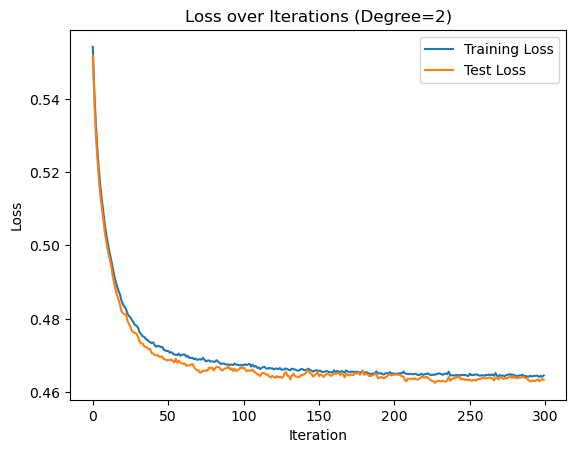

Best Gamma: 0.38285714285714284
Degree: 2
Best Lambda: 1e-05
Best Threshold: 0.7437437437437437
Best F1 Score: 0.4255
Precision: 0.3616
Recall: 0.5169
CONFIGURATION: 
max_iters =  300
gamma =  0.38285714285714284
lambda =  1e-05
batch_size =  10000
nans_threshold =  0.9


In [53]:
## Final model
## Regularized logistic regression with polynomial feature expansion, class weighted SGD and 
## custom LR threshold.  


best_f1 = 0
[x_train, x_test, y_train, y_test] = dhelp.split_data(x_data, y_data, ratio=0.85, seed=1)

# Best degree is 2
for degree in [2]:
    # Preprocess data
    [x_train_degree, x_test_degree, x_validation_degree] = dhelp.preprocess_data(degree, x_train, x_test, x_validation)

    # Convert labels from {-1, 1} to {0, 1}
    y_train_changed = (y_train + 1) / 2
    y_test_changed = (y_test + 1) / 2

    # Setting Inverse Frequencies class weights to account for imabalanced classes
    counter = Counter(y_train_changed)
    N0 = counter[0]
    N1 = counter[1]
    N = N0 + N1
    class_weight = {0: N / (2 * N0), 1: N / (2 * N1)}

    # Grid searching for optimal parameters gamma and lambda
    best_w = w0
    best_lambda = 0
    best_gamma = 0
    best_threshold = 0.5
    best_precision = 0
    best_recall = 0
    for gamma in gamma_values:
        for lambda_ in lambda_values:
            w0 = np.zeros(x_train_degree.shape[1])

            train_losses, test_losses, ws, w_l1_norms = reg_logistic_regression_SGD(
                y_train_changed, x_train_degree, y_test_changed, x_test_degree, w0, max_iters, gamma, lambda_, class_weight, batch_size
            )
            final_w = ws[-1]
            
            # Compute predicted probabilities on test data
            y_test_pred_prob = sigmoid(x_test_degree @ final_w)

            # Finding the best threshold for logistic regression on test data
            thresholds = np.linspace(0.0, 1.0, 1000)
            best_f1_current = 0
            for threshold in thresholds:
                y_test_pred = np.where(y_test_pred_prob >= threshold, 1, 0)

                f1, precision, recall = help.f1_score(y_test_changed, y_test_pred)
                if f1 > best_f1_current:
                    best_precision = precision
                    best_recall = recall
                    best_f1_current = f1
                    best_threshold_current = threshold
            
            # Update best model if current F1 score is higher
            if best_f1_current > best_f1:
                best_train = train_losses
                best_test = test_losses
                best_norm = w_l1_norms
                best_f1 = best_f1_current
                best_w = final_w.copy()
                best_lambda = lambda_
                best_gamma = gamma
                best_threshold = best_threshold_current
                print(f"New best: lambda={lambda_}, gamma={gamma} , F1 score={best_f1_current:.4f}, threshold={best_threshold_current:.4f}")

    indx = range(len(train_losses))
    plt.plot(indx, best_train, label='Training Loss')
    plt.plot(indx, best_test, label='Test Loss')
    #plt.plot(indx, w_l1_norms)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Loss over Iterations (Degree={degree})')
    plt.legend()
    plt.show()

    y_pred_prob = sigmoid(x_validation_degree @ best_w)
    y_pred = np.where(y_pred_prob >= best_threshold, 1, 0)

    y_pred = 2 * y_pred - 1  # Convert back to {-1, 1}

    print(f"Best Gamma: {best_gamma}")
    print(f"Degree: {degree}")
    print(f"Best Lambda: {best_lambda}")
    print(f"Best Threshold: {best_threshold}")
    print(f"Best F1 Score: {best_f1:.4f}")
    print(f"Precision: {best_precision:.4f}")
    print(f"Recall: {best_recall:.4f}")

    print("CONFIGURATION: ")
    print("max_iters = ",max_iters)
    print("gamma = ", gamma)
    print("lambda = ", best_lambda)
    print("batch_size = ", batch_size)
    print("nans_threshold = ", nans_threshold)

    help.create_csv_submission(validation_ids, y_pred, "test_output_2.csv")


New best: lambda=0, gamma=0.1 , F1 score=0.4012


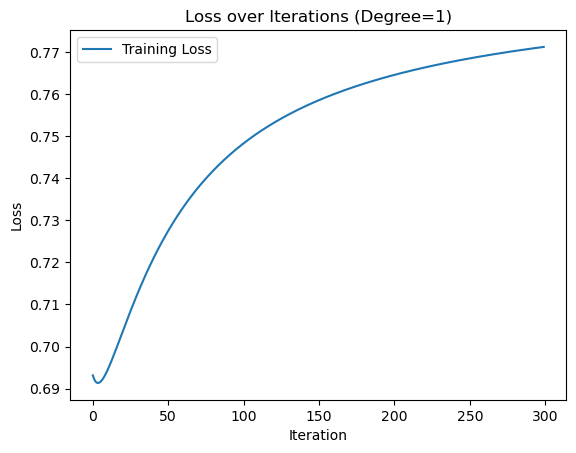

Best Gamma: 0.1
Degree: 1
Best Lambda: 0
Best threshold: 0.22322322322322322
Best F1 Score: 0.4012
Best precision: 0.0000
Best recall: 0.0000
CONFIGURATION: 
max_iters =  300
gamma =  0.001
lambda =  0
batch_size =  10000
nans_threshold =  0.9
New best: lambda=0, gamma=0.1 , F1 score=0.4169
New best: lambda=0.01, gamma=0.1 , F1 score=0.4173


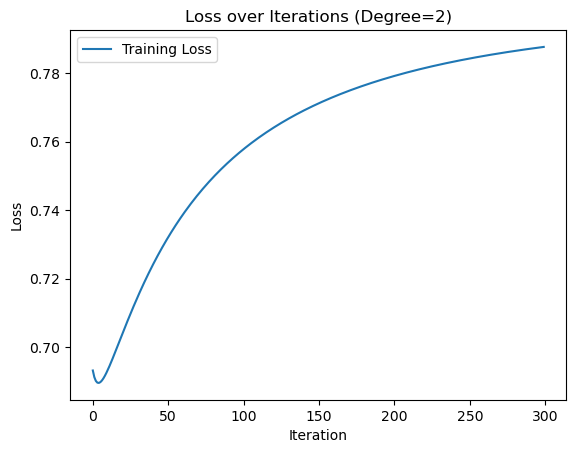

Best Gamma: 0.1
Degree: 2
Best Lambda: 0.01
Best threshold: 0.24624624624624625
Best F1 Score: 0.4173
Best precision: 0.0000
Best recall: 0.0000
CONFIGURATION: 
max_iters =  300
gamma =  0.001
lambda =  0.01
batch_size =  10000
nans_threshold =  0.9


In [50]:
## Model with regular logistic regression and polynomial feature extension,
## while also optimizing LR threshold to maximize F1 Score

[x_train, x_test, y_train, y_test] = dhelp.split_data(x_data, y_data, ratio=0.85, seed=1)

for degree in [1, 2]:
    best_f1 = 0
    # Preprocess data
    [x_train_degree, x_test_degree, x_validation_degree] = dhelp.preprocess_data(degree, x_train, x_test, x_validation)

    # Convert labels from {-1, 1} to {0, 1}
    y_train_changed = (y_train + 1) / 2
    y_test_changed = (y_test + 1) / 2

    # Grid searching for optimal parameters gamma and lambda
    best_w = np.zeros(x_train_degree.shape[1])
    best_lambda = 0
    best_gamma = 0
    best_precision = 0
    best_recall = 0
    best_threshold = 0.5
    max_iters = 300
    for gamma in [0.1, 0.01, 0.001]:
        for lambda_ in lambda_values:
            w0 = np.zeros(x_train_degree.shape[1])

            train_losses, ws = imp.reg_logistic_regression(y_train_changed, x_train_degree, w0, max_iters, gamma, lambda_)
            final_w = ws[-1]

            # Compute predicted probabilities on test data
            y_test_pred_prob = sigmoid(x_test_degree @ final_w)

            # Optimize the threshold
            thresholds = np.linspace(0.0, 1.0, 1000)
            best_f1_current = 0
            for threshold in thresholds:
                y_test_pred = np.where(y_test_pred_prob >= threshold, 1, 0)

                f1, precision, recall = help.f1_score(y_test_changed, y_test_pred)
                if f1 > best_f1_current:
                    best_precision = precision
                    best_recall = recall
                    best_f1_current = f1
                    best_threshold_current = threshold
            
            # Update best model if current F1 score is higher
            if best_f1_current > best_f1:
                best_train = train_losses
                best_f1 = best_f1_current
                best_threshold = best_threshold_current
                best_precision = precision
                best_recall = recall
                best_w = final_w.copy()
                best_lambda = lambda_
                best_gamma = gamma
                print(f"New best: lambda={lambda_}, gamma={gamma} , F1 score={best_f1:.4f}")

    indx = range(len(train_losses))
    plt.plot(indx, best_train, label='Training Loss')
    #plt.plot(indx, w_l1_norms)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Loss over Iterations (Degree={degree})')
    plt.legend()
    plt.show()

    print(f"Best Gamma: {best_gamma}")
    print(f"Degree: {degree}")
    print(f"Best Lambda: {best_lambda}")
    print(f"Best threshold: {best_threshold}")
    print(f"Best F1 Score: {best_f1:.4f}")
    print(f"Best precision: {precision:.4f}")
    print(f"Best recall: {recall:.4f}")

    print("CONFIGURATION: ")
    print("max_iters = ",max_iters)
    print("gamma = ", gamma)
    print("lambda = ", best_lambda)
    print("batch_size = ", batch_size)
    print("nans_threshold = ", nans_threshold)


New best: lambda=1e-05, gamma=0.1 , F1 score=0.1315
New best: lambda=1e-05, gamma=0.01 , F1 score=0.2562
New best: lambda=1e-05, gamma=0.001 , F1 score=0.3634


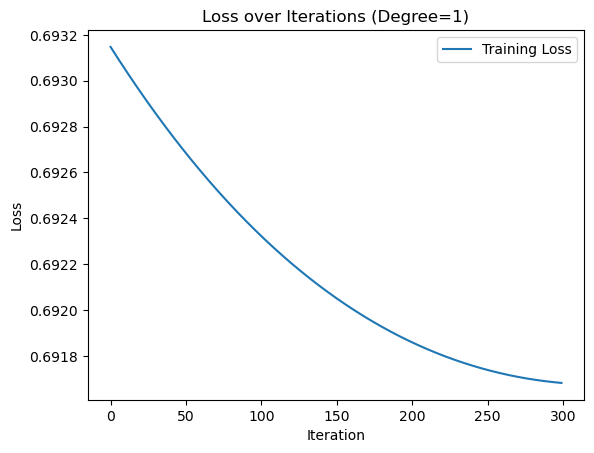

Best Gamma: 0.001
Degree: 1
Best Lambda: 1e-05
Best F1 Score: 0.3634
Best precision: 0.2582
Best recall: 0.6128
CONFIGURATION: 
max_iters =  300
gamma =  0.001
lambda =  1e-05
batch_size =  10000
nans_threshold =  0.9
New best: lambda=1e-05, gamma=0.1 , F1 score=0.2006
New best: lambda=1e-05, gamma=0.01 , F1 score=0.3000
New best: lambda=1e-05, gamma=0.001 , F1 score=0.3530


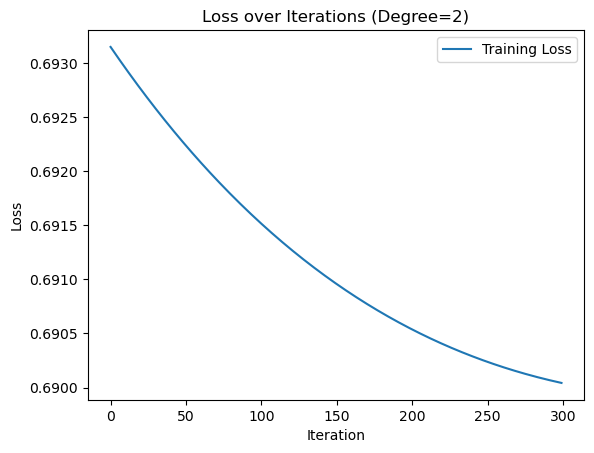

Best Gamma: 0.001
Degree: 2
Best Lambda: 1e-05
Best F1 Score: 0.3530
Best precision: 0.2373
Best recall: 0.6890
CONFIGURATION: 
max_iters =  300
gamma =  0.001
lambda =  1e-05
batch_size =  10000
nans_threshold =  0.9
New best: lambda=1e-05, gamma=0.1 , F1 score=0.2042
New best: lambda=1e-05, gamma=0.01 , F1 score=0.3022
New best: lambda=1e-05, gamma=0.001 , F1 score=0.3440


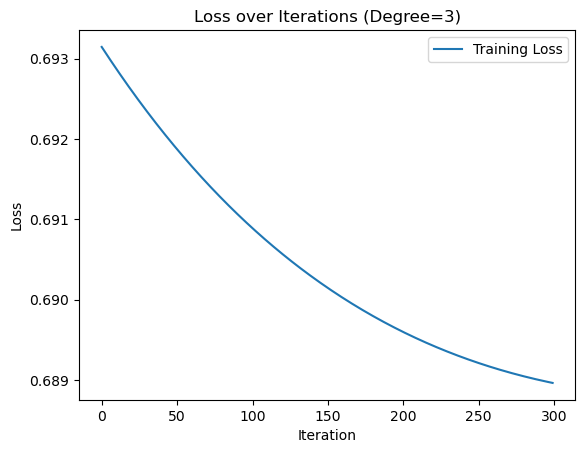

Best Gamma: 0.001
Degree: 3
Best Lambda: 1e-05
Best F1 Score: 0.3440
Best precision: 0.2243
Best recall: 0.7379
CONFIGURATION: 
max_iters =  300
gamma =  0.001
lambda =  1e-05
batch_size =  10000
nans_threshold =  0.9


In [34]:
## Model with regular logistic regression and polynomial feature extension
## F1 score here doesn't improve, as the best degree remains 1 
## Polynomial expansion will help with other models

[x_train, x_test, y_train, y_test] = dhelp.split_data(x_data, y_data, ratio=0.85, seed=1)

degree_vector = [1,2,3]

for degree in degree_vector:
    best_f1 = 0
    # Preprocess data
    [x_train_degree, x_test_degree, x_validation_degree] = dhelp.preprocess_data(degree, x_train, x_test, x_validation)

    # Convert labels from {-1, 1} to {0, 1}
    y_train_changed = (y_train + 1) / 2
    y_test_changed = (y_test + 1) / 2

    # Grid searching for optimal parameters gamma and lambda
    best_w = np.zeros(x_train_degree.shape[1])
    best_lambda = 0
    best_gamma = 0
    best_precision = 0
    best_recall = 0
    max_iters = 300
    for gamma in [0.1, 0.01, 0.001]:
        for lambda_ in lambda_values:
            w0 = np.zeros(x_train_degree.shape[1])

            train_losses, ws = imp.reg_logistic_regression(y_train_changed, x_train_degree, w0, max_iters, gamma, lambda_)
            final_w = ws[-1]

            # Compute predicted probabilities on test data
            y_test_pred_prob = sigmoid(x_test_degree @ final_w)

            # Calculate f1 score
            y_test_pred = np.where(y_test_pred_prob >= 0.5, 1, 0)
            f1, precision, recall = help.f1_score(y_test_changed, y_test_pred)
            
            # Update best model if current F1 score is higher
            if f1 > best_f1:
                best_train = train_losses
                best_f1 = f1
                best_precision = precision
                best_recall = recall
                best_w = final_w.copy()
                best_lambda = lambda_
                best_gamma = gamma
                print(f"New best: lambda={lambda_}, gamma={gamma} , F1 score={f1:.4f}")

    indx = range(len(train_losses))
    plt.plot(indx, best_train, label='Training Loss')
    #plt.plot(indx, w_l1_norms)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Loss over Iterations (Degree={degree})')
    plt.legend()
    plt.show()

    y_pred_prob = sigmoid(x_validation_degree @ best_w)
    y_pred = np.where(y_pred_prob >= 0.5, 1, 0)

    y_pred = 2 * y_pred - 1  # Convert back to {-1, 1}

    print(f"Best Gamma: {best_gamma}")
    print(f"Degree: {degree}")
    print(f"Best Lambda: {best_lambda}")
    print(f"Best F1 Score: {best_f1:.4f}")
    print(f"Best precision: {precision:.4f}")
    print(f"Best recall: {recall:.4f}")

    print("CONFIGURATION: ")
    print("max_iters = ",max_iters)
    print("gamma = ", gamma)
    print("lambda = ", best_lambda)
    print("batch_size = ", batch_size)
    print("nans_threshold = ", nans_threshold)


New best: lambda=1e-05, gamma=0.001 , F1 score=0.3634


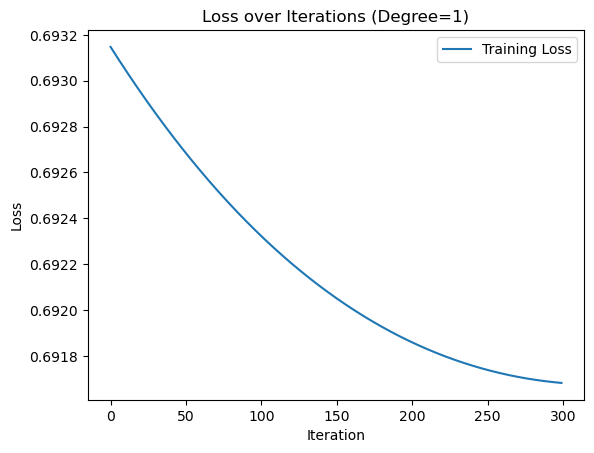

Best Gamma: 0.001
Degree: 1
Best Lambda: 1e-05
Best F1 Score: 0.3634
Best precision: 0.2411
Best recall: 0.6674
CONFIGURATION: 
max_iters =  300
gamma =  0.0001
lambda =  1e-05
batch_size =  10000
nans_threshold =  0.9


In [32]:
## Baseline model 
## Regularized logistic regression
## No polynomial features, SGD, class weights and LR threshold

best_f1 = 0
[x_train, x_test, y_train, y_test] = dhelp.split_data(x_data, y_data, ratio=0.85, seed=1)

degree = 1
# Preprocess data (with degree=1 this is just standardization + including bias column)
[x_train_degree, x_test_degree, x_validation_degree] = dhelp.preprocess_data(degree, x_train, x_test, x_validation)

# Convert labels from {-1, 1} to {0, 1}
y_train_changed = (y_train + 1) / 2
y_test_changed = (y_test + 1) / 2

# Grid searching for optimal parameters gamma and lambda
best_w = np.zeros(x_train_degree.shape[1])
best_lambda = 0
best_gamma = 0
best_precision = 0
best_recall = 0
max_iters = 300
for gamma in [0.001, 0.0001]:
    for lambda_ in lambda_values:
        w0 = np.zeros(x_train_degree.shape[1])

        train_losses, ws = imp.reg_logistic_regression(y_train_changed, x_train_degree, w0, max_iters, gamma, lambda_)
        final_w = ws[-1]

        # Compute predicted probabilities on test data
        y_test_pred_prob = sigmoid(x_test_degree @ final_w)

        # Calculate f1 score
        y_test_pred = np.where(y_test_pred_prob >= 0.5, 1, 0)
        f1, precision, recall = help.f1_score(y_test_changed, y_test_pred)
        
        # Update best model if current F1 score is higher
        if f1 > best_f1:
            best_train = train_losses
            best_f1 = f1
            best_precision = precision
            best_recall = recall
            best_w = final_w.copy()
            best_lambda = lambda_
            best_gamma = gamma
            print(f"New best: lambda={lambda_}, gamma={gamma} , F1 score={f1:.4f}")

indx = range(len(train_losses))
plt.plot(indx, best_train, label='Training Loss')
#plt.plot(indx, w_l1_norms)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title(f'Loss over Iterations (Degree={degree})')
plt.legend()
plt.show()

y_pred_prob = sigmoid(x_validation_degree @ best_w)
y_pred = np.where(y_pred_prob >= 0.5, 1, 0)

y_pred = 2 * y_pred - 1  # Convert back to {-1, 1}

print(f"Best Gamma: {best_gamma}")
print(f"Degree: {degree}")
print(f"Best Lambda: {best_lambda}")
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Best precision: {precision:.4f}")
print(f"Best recall: {recall:.4f}")

print("CONFIGURATION: ")
print("max_iters = ",max_iters)
print("gamma = ", gamma)
print("lambda = ", best_lambda)
print("batch_size = ", batch_size)
print("nans_threshold = ", nans_threshold)
